In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn import ensemble
from yellowbrick.features import RFECV
from sklearn import feature_selection
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

C:\Users\askid\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\askid\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Introduction:
The purpose of this study is to see if we can predict how often a given news article will be shared online. The data set, taken from the University of California Irvine machine learning archive, contains almost 40,000 observations, each being a different data set, and 61 attributes such as metrics on the words of each article, sentiment analysis of each article, and indicative variables on when the article was published. I will attempt to use the processes of data normalization, correlation and variance thresholds, and PCA to select the best numeric attributes. For the categorical values, I will attempt to use correlation thresholds, VIF values, and stepwise selection to narrow down the best categorical variables. In addition, I will need to use some domain knowledge from the data itself to divide variables and take some out.

### EDA: Data Import and Structuring:
First step, as always is to import the data set and check the column names to use some domain knowledge to initially remove certain attributes and separate the numeric and categorical variables into the proper data sets.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Data%20Sets/Module%204/M4_Data.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


### EDA: Splitting the Data

In [3]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
train_set.columns
#after checking out the names of the columns and reviewing the information, I chose 
#categorical columns that needed to be eliminated before doing any dimensional reduction

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

Creating a copy of the original dataframe to preserve it before dropping columns, I then proceeded to remove any attributes that either didn't matter or were categorical. URL was taken out as it is just indicative and the title of the article in question. The other columns taken out are all categorical indicating what type of article it is and when it was published. These can come back as highly correlated with each other and should be dealt with in other ways, for instance is_weekend is dependent on weekday_is_saturday and weekday_is_sunday but these will be addressed later.

In [5]:
df1 = train_set.copy()
df1.drop(columns='url', inplace=True)
df1.drop(columns=' data_channel_is_lifestyle', inplace=True)
df1.drop(columns=' data_channel_is_entertainment', inplace=True)
df1.drop(columns=' data_channel_is_bus', inplace=True)
df1.drop(columns=' data_channel_is_socmed', inplace=True)
df1.drop(columns=' data_channel_is_tech', inplace=True)
df1.drop(columns=' data_channel_is_world', inplace=True)
df1.drop(columns=' weekday_is_monday', inplace=True)
df1.drop(columns=' weekday_is_tuesday', inplace=True)
df1.drop(columns=' weekday_is_wednesday', inplace=True)
df1.drop(columns=' weekday_is_thursday', inplace=True)
df1.drop(columns=' weekday_is_friday', inplace=True)
df1.drop(columns=' weekday_is_saturday', inplace=True)
df1.drop(columns=' weekday_is_sunday', inplace=True)
df1.drop(columns=' is_weekend', inplace=True)
df1.columns

Index([' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' kw_min_min', ' kw_max_min',
       ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max',
       ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg',
       ' self_reference_min_shares', ' self_reference_max_shares',
       ' self_reference_avg_sharess', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
       ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_ti

Before moving into the steps of correlation examining, PCA, and variance examining, it's important to evaluate the amount of missing values and scaling the dataset to it is easier to understand the variance. Thankfully there are none so that we can move on to normalizing the data to examine the variance so that it's easier to compare across attributes.

In [6]:
print('Total Amount of Missing Values: ', df1.isna().sum().sum())

Total Amount of Missing Values:  0


In [7]:
d = preprocessing.normalize(df1, axis = 0)
scaled_df = pd.DataFrame(d, columns=df1.columns)
scaled_df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,0.004588,0.007934,0.004857,0.000720,0.000946,0.000975,0.005002,0.001112,0.000592,0.0,...,0.001582,0.005637,-0.005033,-0.004700,-0.003905,0.005981,0.006780,0.000599,0.006780,0.007370
1,0.009706,0.005818,0.003163,0.000734,0.000946,0.000994,0.000715,0.000000,0.000592,0.0,...,0.006472,0.003523,-0.002589,-0.001567,-0.003905,0.000000,0.000000,0.007191,0.000000,0.000233
2,0.003557,0.003702,0.002668,0.000861,0.000946,0.001185,0.001787,0.002224,0.000592,0.0,...,0.002967,0.004228,-0.005489,-0.007519,-0.001953,0.000000,0.000000,0.007191,0.000000,0.000595
3,0.003787,0.005818,0.001678,0.000820,0.000946,0.001172,0.002858,0.002224,0.001775,0.0,...,0.001582,0.003523,-0.001907,-0.001175,-0.002789,0.007178,0.004068,0.000719,0.004068,0.001419
4,0.008783,0.006876,0.000951,0.001045,0.000946,0.001341,0.001072,0.000000,0.000592,0.0,...,0.009493,0.007046,-0.010681,-0.009399,-0.003905,0.000000,0.000000,0.007191,0.000000,0.003159


### EDA: Looking into Metrics
After creating a normalized set of data, we can move on to real EDA. Some of the methods that will be used to select the proper features to bring into the PCA and stepwise process will be to look at the rankings of correlation and variance. It is possible to run all 60 through a PCA algorithm but that will be extremely computationally expensive to run so if we can eliminate a few of them so that the process isn't trying to be run in 60 dimensions, it can greatly help.

In [8]:
scaled_df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,...,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,3.171500e+04
mean,0.004806,0.005502,0.004256,0.000780,0.000949,0.001048,0.003892,0.003666,0.002699,0.001623,...,0.004505,0.005336,-0.005039,-0.004907,-0.004195,0.003689,0.001446,0.004917,0.003186,1.562151e-03
std,0.002904,0.001122,0.003663,0.005561,0.005535,0.005517,0.004047,0.004254,0.004924,0.005376,...,0.003352,0.001749,0.002478,0.002730,0.003732,0.004234,0.005426,0.002713,0.004624,5.393647e-03
min,0.000109,0.001058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.019419,-0.009399,-0.039050,0.000000,-0.020340,0.000000,0.000000,4.577907e-07
25%,0.002226,0.004760,0.001910,0.000665,0.000946,0.000946,0.001429,0.001112,0.000592,0.000000,...,0.002373,0.004228,-0.006373,-0.006579,-0.004881,0.000000,0.000000,0.002397,0.000000,4.339856e-04
50%,0.004602,0.005289,0.003186,0.000761,0.000946,0.001043,0.002858,0.003336,0.000592,0.000000,...,0.004746,0.005637,-0.004923,-0.004700,-0.003905,0.001958,0.000000,0.007191,0.000000,6.409069e-04
75%,0.007344,0.006347,0.005568,0.000859,0.000946,0.001140,0.005002,0.004448,0.002366,0.001291,...,0.004746,0.007046,-0.003630,-0.002820,-0.001953,0.006525,0.002906,0.007191,0.005085,1.281814e-03
max,0.009923,0.012165,0.057331,0.990470,0.986128,0.982597,0.108622,0.129001,0.075727,0.117505,...,0.047464,0.007046,0.000000,0.000000,0.000000,0.013050,0.020340,0.007191,0.020340,3.860549e-01


After normalizing the data, the top 5 in variance can be seen below. What is interesting to note is that none of those five appear in the top five of the correlation rankings against shares.

In [9]:
scaled_df.var().sort_values(ascending=False).head()

 n_unique_tokens              0.000031
 n_non_stop_words             0.000031
 n_non_stop_unique_tokens     0.000030
 self_reference_min_shares    0.000030
 kw_min_max                   0.000030
dtype: float64

In [10]:
corr = df1.corr()
corr[' shares'].sort_values(ascending=False).head()

 shares        1.000000
 kw_avg_avg    0.106740
 LDA_03        0.085382
 kw_max_avg    0.061870
 num_hrefs     0.046526
Name:  shares, dtype: float64

There are way too many variables to show a boxplot or histogram of all 60 attributes so I will have to try and eliminate some values based on correlation before moving on. As can be shown by the chart code below, none of the numeric values have a high correlation value with the response, the highest being only 11% and the lowest being just about 0. For this reason, I will assume that these values are clouded by all of the noise that is going on in the model which is what we are trying to clean up so I will narrow the values down to the top 10 in correlation and from there hope to find that a significant amount are in the top attributes for variance as well. These values for correlation are kw_avg_avg, LDA_03, kw_max_avg, self_reference_avg_sharess, LDA_02, self_reference_min_shares, self_reference_max_shares, num_hrefs, kw_avg_max, and kw_min_avg. For variance using the scaled dataframe, the top 10 are n_unique_tokens, n_non_stop_words, self_reference_min_shares, n_non_stop_unique_tokens, kw_min_max, self_reference_max_shares, self_reference_avg_sharess, title_sentiment_polarity, kw_max_min, and num_videos. There are a few overlapping including self_reference_avg_sharess, self_reference_min_shares, and self_reference_max_shares.

In [11]:
corr[' shares'].sort_values(ascending=False)

 shares                          1.000000
 kw_avg_avg                      0.106740
 LDA_03                          0.085382
 kw_max_avg                      0.061870
 num_hrefs                       0.046526
 self_reference_avg_sharess      0.044519
 kw_avg_max                      0.041734
 self_reference_min_shares       0.040790
 self_reference_max_shares       0.039183
 kw_min_avg                      0.037683
 num_imgs                        0.037407
 global_subjectivity             0.032716
 kw_avg_min                      0.031659
 kw_max_min                      0.031134
 abs_title_sentiment_polarity    0.027584
 num_videos                      0.025578
 num_keywords                    0.023550
 title_subjectivity              0.021779
 avg_positive_polarity           0.014755
 title_sentiment_polarity        0.012638
 n_tokens_title                  0.012481
 max_positive_polarity           0.011442
 global_sentiment_polarity       0.011113
 timedelta                       0

In [12]:
scaled_df.var().sort_values(ascending=False)

 n_unique_tokens                 0.000031
 n_non_stop_words                0.000031
 n_non_stop_unique_tokens        0.000030
 self_reference_min_shares       0.000030
 kw_min_max                      0.000030
 self_reference_max_shares       0.000030
 title_sentiment_polarity        0.000029
 self_reference_avg_sharess      0.000029
 kw_max_min                      0.000029
 shares                          0.000029
 num_videos                      0.000029
 kw_min_min                      0.000028
 kw_avg_min                      0.000026
 num_imgs                        0.000024
 LDA_01                          0.000022
 abs_title_sentiment_polarity    0.000021
 LDA_00                          0.000021
 LDA_03                          0.000020
 LDA_02                          0.000020
 LDA_04                          0.000019
 num_self_hrefs                  0.000018
 title_subjectivity              0.000018
 kw_max_avg                      0.000017
 num_hrefs                       0

In [13]:
toPlot = scaled_df[[' shares',' kw_avg_avg',' LDA_03',' kw_max_avg',' self_reference_avg_sharess',' self_reference_min_shares',
                    ' self_reference_max_shares',' num_hrefs',' kw_avg_max',' kw_min_avg',' num_imgs',' global_subjectivity',
                   ' kw_avg_min',' kw_max_min',' LDA_02']]
len(toPlot.columns)

15

### EDA: Examining Charts
Running the data through PCA will automatically look at the highest variance attributes so I will use correlation to try and eliminate some of the 48 numeric attributes. In particular, I will be examining the highest correlation attributes against their distributions in histograms and the apparent variance and spread of values in boxplots. Since there are 48 attributes I will try and eliminate a significant amount of them to be able to analyze every chart. I will incorporate only the attributes above 3%. This This will still leave a lot of attributes to plot but will hopefully relieve some of the burden.

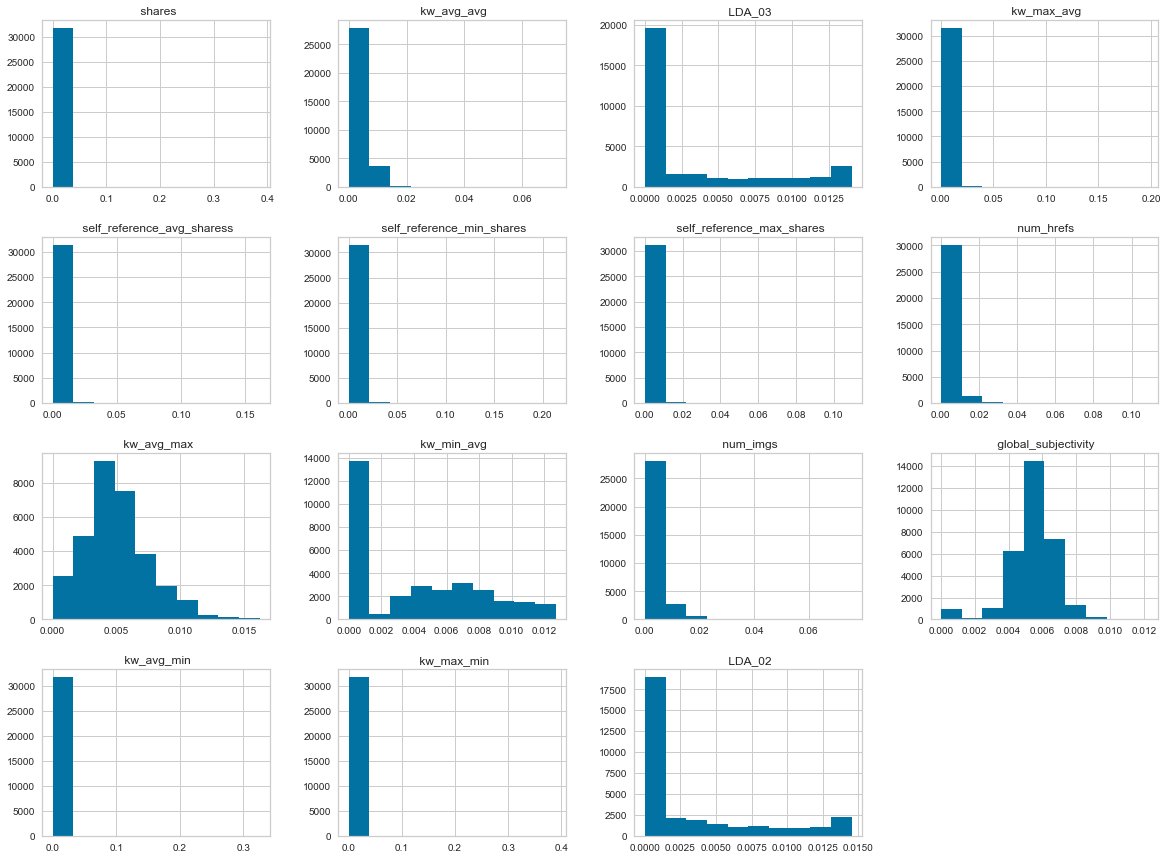

In [14]:
toPlot.hist(bins=10, figsize=(20,15))
plt.show()

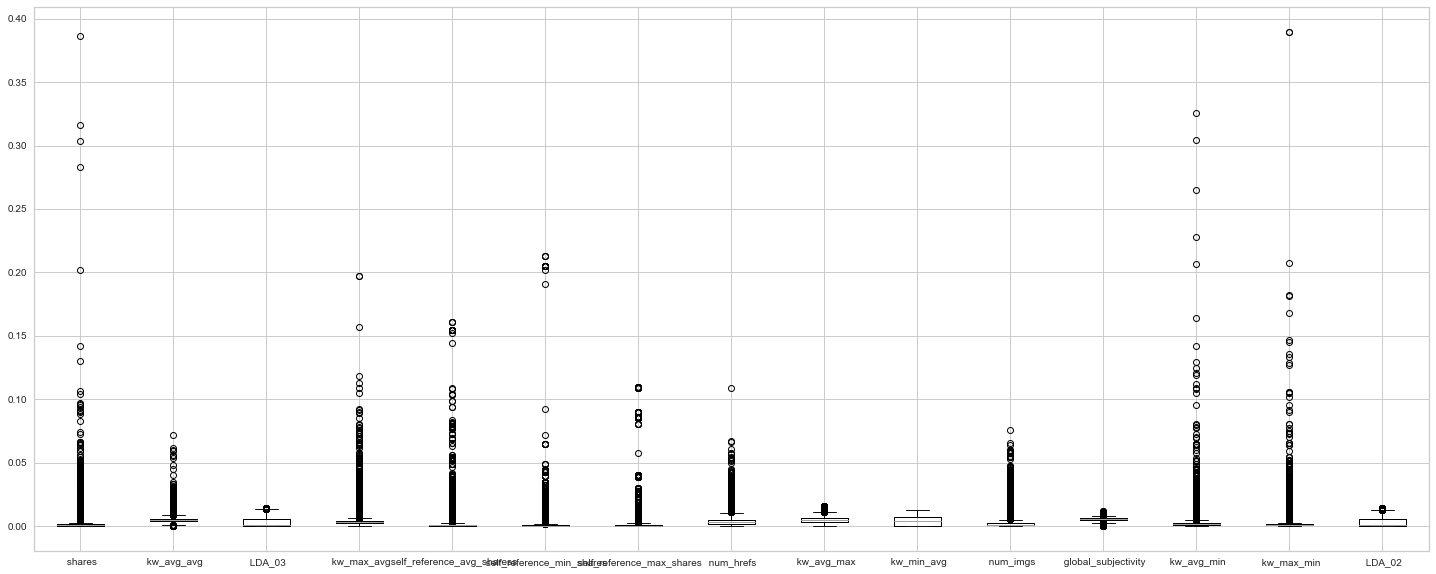

In [15]:
boxplot=toPlot.boxplot(figsize=(25,10))

Looking at the distribution of these top correlation variables, nine out of 15 have little to know variance and can likely be eliminated as they won't contribute much to the RMSE even before looking into PCA. The boxplot shows us similar, that the amount of outliers from the quartiles is massive and are largely centered around certain values. Using this information, I feel that it is safe to eliminate some of the values here including kw_avg_avg, kw_max_avg, self_reference_avg_sharess, self_reference_min_shares, self_reference_max_shares, num_hrefs, num_imgs, kw_avg_min, and kw_max_min.

### Feature Selection/Dimensionality Reduction: PCA
Now that I've narrowed down these down to just five, I can start putting these in a PCA algorithm. Using the recommended 95% explained variance, I decided to generate two lists of the top PCA components, one for the small subset that I selected from those that were plotted and one of all attributes that were plotted so that I would have a choice of models to see which performs better.

This first round of PCA uses 4 components to reach the desired explanation of variance and in this case it exceeds 95% and gets to 97%. The attributes we are left with are LDA_02, LDA_03, kw_avg_max, and kw_min_avg.

In [16]:
Y_train = toPlot[' shares'].copy()
X_train = toPlot[[' LDA_03',' kw_avg_max', ' kw_min_avg', ' global_subjectivity', ' LDA_02']]
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

4

In [17]:
pca = PCA(n_components = 4)
X2D = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_, sum(np.array(pca.explained_variance_ratio_)))
comps = pd.DataFrame(pca.components_,columns=X_train.columns)
min_val = 0.20358392
num_components = 4
pca_cols = set()
for i in range(num_components):
    parts = comps.iloc[i][
        comps.iloc[i].abs() > min_val
    ]
    pca_cols.update(set(parts.index))
pca_cols

[0.44620637 0.24659103 0.20358392 0.07372983] 0.9701111418716042


{' LDA_02', ' LDA_03', ' kw_avg_max', ' kw_min_avg'}

In [18]:
Y_train_2 = toPlot[' shares'].copy()
X_train_2 = toPlot.iloc[:,1:15]
pca2 = PCA()
pca2.fit(X_train_2)
cumsum2 = np.cumsum(pca2.explained_variance_ratio_)
d2 = np.argmax(cumsum2 >= 0.95) + 1
d2

9

In [19]:
pca2 = PCA(n_components = 9)
X2D = pca2.fit_transform(X_train_2)
print(pca2.explained_variance_ratio_, sum(np.array(pca2.explained_variance_ratio_)))
comps = pd.DataFrame(pca2.components_,columns=X_train_2.columns)
min_val = 0.03393019
num_components = 9
pca_cols = set()
for i in range(num_components):
    parts = comps.iloc[i][
        comps.iloc[i].abs() > min_val
    ]
    pca_cols.update(set(parts.index))
pca_cols

[0.27052615 0.22471211 0.12860301 0.08826734 0.06554088 0.05978046
 0.04831299 0.04551826 0.03393019] 0.9651913906780932


{' LDA_02',
 ' LDA_03',
 ' global_subjectivity',
 ' kw_avg_avg',
 ' kw_avg_max',
 ' kw_avg_min',
 ' kw_max_avg',
 ' kw_max_min',
 ' kw_min_avg',
 ' num_hrefs',
 ' num_imgs',
 ' self_reference_avg_sharess',
 ' self_reference_max_shares',
 ' self_reference_min_shares'}

In this second round of PCA, we use 9 components to reach the desired explanation of variance and in this case it exceeds 95% and gets to 96%. We are left with LDA_02, LDA_03, global_subjectivity, kw_avg_avg, kw_avg_max, kw_avg_min, kw_max_avg, kw_max_min, kw_min_avg, num_hrefs, num_imgs, self_reference_avg_sharess, self_reference_max_shares, and self_reference_min_shares.

### Feature Selection/Dimensionality Reduction: VIF
Now that the numeric columns are set, we can move on to the categorical variables. I decided to still exclude URL since it's indicative, nothing more than an ID so it likely provides no useful information.

In [20]:
df2 = train_set.copy()
df2 = df2[[' shares',' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
           ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',' weekday_is_monday',
           ' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',' weekday_is_friday',' weekday_is_saturday',
          ' weekday_is_sunday',' is_weekend']]

Usually the first thing to check is the correlation between these and the response variable. However, thanks to some domain knowledge, I know that some of these columns are very closely associated. For instance, all of the data_channel columns are related because if the article isn't about one category it's about another. Similarly with weekdays, it is a dummy variable meaning that they are all interrelated. Perhaps the most interrelated variable is is_weekend. This is just indicative of if the observation has a 1 value filled in for weekday_is_saturday or weekday_is_sunday. Therefore, it's important to check VIF values to see if any of them are skewing the model before applying stepwise selection.

In [21]:
vif_data = pd.DataFrame()
vif_data['feature'] = df2.columns
vif_data['VIF'] = [variance_inflation_factor(df2.values, i)
                      for i in range(len(df2.columns))]
vif_data

C:\Users\askid\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,shares,1.010841
1,data_channel_is_lifestyle,1.277549
2,data_channel_is_entertainment,1.793773
3,data_channel_is_bus,1.724508
4,data_channel_is_socmed,1.306590
5,data_channel_is_tech,1.814540
6,data_channel_is_world,1.896118
7,weekday_is_monday,2.029885
8,weekday_is_tuesday,2.095337
9,weekday_is_wednesday,2.097535


While most of the values have moderate correlation and can be left in before going to stepwise selection, weekday_is_saturday, weekday_is_sunday, and is_weekend are all perfectly correlated with each other, as predicted. This means that one will need to be removed and we will need to do some trial and error to find the best combinations out of those three (https://stackoverflow.com/questions/60163405/vif-function-returns-all-inf-values)

In [22]:
x = df2[[' shares',' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
           ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',' weekday_is_monday',
           ' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',' weekday_is_friday',' weekday_is_saturday',
          ' weekday_is_sunday']]
vif_data = pd.DataFrame()
vif_data['feature'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i)
                      for i in range(len(x.columns))]
vif_data

,feature,VIF
0,shares,1.010841
1,data_channel_is_lifestyle,1.277549
2,data_channel_is_entertainment,1.793773
3,data_channel_is_bus,1.724508
4,data_channel_is_socmed,1.306590
5,data_channel_is_tech,1.814540
6,data_channel_is_world,1.896118
7,weekday_is_monday,2.029885
8,weekday_is_tuesday,2.095337
9,weekday_is_wednesday,2.097535


Removing is_weekend, which is based solely off of weekday_is_sunday and weekday_is_saturday, cleans up the variables and we can move forward with stepwise selection.

I'll have to perform stepwise selection twice, one for each resulting dataset from the PCA testing and from there I can go on and evaluate each model.

In [23]:
df1 = train_set[[' shares',' LDA_03',' kw_avg_max',' kw_min_avg',' global_subjectivity',' LDA_02',' data_channel_is_lifestyle',
              ' data_channel_is_entertainment',' data_channel_is_bus',' data_channel_is_socmed',' data_channel_is_tech',
             ' data_channel_is_world',' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',
             ' weekday_is_friday',' weekday_is_saturday',' weekday_is_sunday']].copy()
y = df1[' shares'].copy()
X = df1.drop(columns=' shares').copy()
X = sm.add_constant(X)

C:\Users\askid\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [24]:
def get_stats():
    results = sm.OLS(y, X).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     24.08
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           6.87e-76
Time:                        21:54:03   Log-Likelihood:            -3.4210e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31697   BIC:                         6.844e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [25]:
X.drop(columns=' kw_avg_max', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     25.46
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.57e-76
Time:                        21:54:05   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31698   BIC:                         6.844e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [26]:
X.drop(columns=' weekday_is_thursday', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     25.46
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.57e-76
Time:                        21:54:07   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31698   BIC:                         6.844e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [27]:
X.drop(columns=' weekday_is_tuesday', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     27.14
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           7.62e-77
Time:                        21:54:12   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31699   BIC:                         6.844e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [28]:
X.drop(columns=' weekday_is_friday', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     29.05
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           1.68e-77
Time:                        21:54:16   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31700   BIC:                         6.844e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [29]:
X.drop(columns=' weekday_is_wednesday', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     31.21
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           4.57e-78
Time:                        21:54:19   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31701   BIC:                         6.844e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [30]:
X.drop(columns=' weekday_is_sunday', inplace=True)
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     33.74
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           1.22e-78
Time:                        21:54:23   Log-Likelihood:            -3.4211e+05
No. Observations:               31715   AIC:                         6.842e+05
Df Residuals:                   31702   BIC:                         6.843e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Using all variables and the first results of the PCA selection, the R squared value of this model is miniscule and yet a significant amount of predictors are relevant. Taking each attribute out one at a time, the model doesn't perform any better. This leads me to believe that the second PCA option is better since it incorporates more.

In [31]:
df3 = train_set[[' shares',' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
                ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',' weekday_is_monday',
                ' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',' weekday_is_friday',' weekday_is_saturday'
                ,' weekday_is_sunday',' LDA_02',' LDA_03',' global_subjectivity',' kw_avg_avg',' kw_avg_max',' kw_avg_min',
                ' kw_max_avg',' kw_max_min',' kw_min_avg',' num_hrefs',' num_imgs',' self_reference_avg_sharess',
                ' self_reference_max_shares',' self_reference_min_shares']]
y = df3[' shares'].copy()
X = df3.drop(columns=' shares').copy()

In [32]:
def get_stats():
    results = sm.OLS(y, X).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     24.51
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          1.85e-116
Time:                        21:54:32   Log-Likelihood:            -3.4199e+05
No. Observations:               31715   AIC:                         6.840e+05
Df Residuals:                   31688   BIC:                         6.843e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
 data_channe

In [33]:
X.drop(columns=[' weekday_is_thursday'], inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              128.8
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:42   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31689   BIC:                                  6.843e+05
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [34]:
X.drop(columns=' self_reference_avg_sharess', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              134.0
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:45   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31690   BIC:                                  6.842e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [35]:
X.drop(columns=' weekday_is_tuesday', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              139.5
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:49   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31691   BIC:                                  6.842e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [36]:
X.drop(columns=' weekday_is_friday', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              145.6
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:51   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31692   BIC:                                  6.842e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [37]:
X.drop(columns=' kw_avg_min', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              152.2
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:53   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31693   BIC:                                  6.842e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [38]:
X.drop(columns=' num_imgs',inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              159.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:56   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31694   BIC:                                  6.842e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [39]:
X.drop(columns=' weekday_is_sunday',inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              167.3
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:54:58   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31695   BIC:                                  6.842e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [40]:
X.drop(columns=' weekday_is_wednesday', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              176.0
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:00   Log-Likelihood:                     -3.4199e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31696   BIC:                                  6.842e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [41]:
X.drop(columns=' data_channel_is_world', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              185.7
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:03   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31697   BIC:                                  6.842e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [42]:
X.drop(columns=' data_channel_is_socmed',inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              196.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:04   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31698   BIC:                                  6.842e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [43]:
X.drop(columns=' kw_max_min', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              208.5
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:07   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31699   BIC:                                  6.842e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [44]:
X.drop(columns=' data_channel_is_tech', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              222.2
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:10   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31700   BIC:                                  6.842e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [45]:
X.drop(columns=' global_subjectivity', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              237.9
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:13   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31701   BIC:                                  6.841e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [46]:
X.drop(columns=' data_channel_is_bus', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              256.0
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:22   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31702   BIC:                                  6.841e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [47]:
X.drop(columns=' data_channel_is_lifestyle', inplace=True)
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              277.2
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:55:24   Log-Likelihood:                     -3.4200e+05
No. Observations:               31715   AIC:                                  6.840e+05
Df Residuals:                   31703   BIC:                                  6.841e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Performing stepwise selection on the second round of PCA didn't prove successful either, even after moving from variable to variable removing the ones with a high p value, the R squared still didn't improve beyond 0.095. In my opinion this data set may be more useful for a classification model since it has a lot of classification variable and we would need to go back to the drawing board.

### Conclusion:
After looking through this data, seemingly it wouldn't be hard to use as the basis of a predictive model since it has so many predictors but when it comes to a linear regression it seems tough to nail down. It seems that even after looking through the variables listed there are still some missing. I think that a reason for this may be because so many of the variables are dependent on each other, for instance the day ones. This data set requires more variable manipulation in the form of engineering. In my opinion, this data set would be better for classification due to the amount of classification variables but it requires more looking into the interactive variables.